In [2]:
# Detect environment and set paths accordingly
import os

try:
    # Check if running in Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_ROOT = "/content/drive/MyDrive/dbpedia_project"
    print("Running in Google Colab. Using Google Drive path.")
except ImportError:
    # Running locally - use local dbpedia_project directory
    DRIVE_ROOT = os.path.join(os.getcwd(), "dbpedia_project")
    print(f"Running locally. Using local path: {DRIVE_ROOT}")

Running locally. Using local path: c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\dbpedia_project


In [3]:
import os
os.makedirs(DRIVE_ROOT, exist_ok=True)
os.makedirs(os.path.join(DRIVE_ROOT, "model"), exist_ok=True)
os.makedirs(os.path.join(DRIVE_ROOT, "checkpoints"), exist_ok=True)

In [4]:
TRAIN_PATH = os.path.join(DRIVE_ROOT, "train.csv")
TEST_PATH  = os.path.join(DRIVE_ROOT, "test.csv")
MODEL_SAVE_DIR = os.path.join(DRIVE_ROOT, "model")
CHECKPOINTS_DIR = os.path.join(DRIVE_ROOT, "checkpoints")

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH:", TEST_PATH)
print("MODEL_SAVE_DIR:", MODEL_SAVE_DIR)

TRAIN_PATH: c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\dbpedia_project\train.csv
TEST_PATH: c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\dbpedia_project\test.csv
MODEL_SAVE_DIR: c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\dbpedia_project\model


In [5]:
!pip install -q transformers datasets evaluate

In [6]:
!pip install -q scikit-learn pandas matplotlib seaborn

In [7]:
!pip install -q lime shap

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 2
  ╰─> [901 lines of output]
      + meson setup C:\Users\johnb\AppData\Local\Temp\pip-install-hzn5s8dg\scikit-image_62f8e466318d477f99cb85257c0d6be8 C:\Users\johnb\AppData\Local\Temp\pip-install-hzn5s8dg\scikit-image_62f8e466318d477f99cb85257c0d6be8\.mesonpy-ag3ic6ra -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\johnb\AppData\Local\Temp\pip-install-hzn5s8dg\scikit-image_62f8e466318d477f99cb85257c0d6be8\.mesonpy-ag3ic6ra\meson-python-native-file.ini
      The Meson build system
      Version: 1.9.1
      Source dir: C:\Users\johnb\AppData\Local\Temp\pip-install-hzn5s8dg\scikit-image_62f8e466318d477f99cb85257c0d6be8
      Build dir: C:\Users\johnb\AppData\Local\Temp\pip-install-hzn5s8dg\scikit-image_62f8e466318d477f99cb85257c0d6be8\.mesonpy-ag3ic6ra
      Build type: native build
      Activating VS 16.11.51
      Project name: scikit

In [8]:
!pip install torch

In [9]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)


#Load DBpedia Dataset

In [10]:
train_df = pd.read_csv(TRAIN_PATH, header=None, names=["label","title","text"])
test_df  = pd.read_csv(TEST_PATH,  header=None, names=["label","title","text"])

train_df["text"] = train_df["title"].fillna("").astype(str) + ". " + train_df["text"].fillna("").astype(str)
test_df["text"]  = test_df["title"].fillna("").astype(str) + ". " + test_df["text"].fillna("").astype(str)

train_df = train_df[train_df["text"].str.strip().astype(bool)]
test_df  = test_df[test_df["text"].str.strip().astype(bool)]

if train_df["label"].max() > 13:
    train_df["label"] -= 1
    test_df["label"]  -= 1

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (560000, 3)
Test shape: (70000, 3)


In [11]:
train_df.head()

,label,title,text
0,0,E. D. Abbott Ltd,E. D. Abbott Ltd. Abbott of Farnham E D Abbot...
1,0,Schwan-Stabilo,Schwan-Stabilo. Schwan-STABILO is a German ma...
2,0,Q-workshop,Q-workshop. Q-workshop is a Polish company lo...
3,0,Marvell Software Solutions Israel,Marvell Software Solutions Israel. Marvell So...
4,0,Bergan Mercy Medical Center,Bergan Mercy Medical Center. Bergan Mercy Med...


#Train/Validation Split

In [12]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"], train_df["label"], test_size=0.1, stratify=train_df["label"], random_state=42
)

print("Train:", len(train_texts), "Val:", len(val_texts))


Train: 504000 Val: 56000


#EDA (Class Distribution + Stats + Examples)

###Class Distribution

C:\Users\johnb\AppData\Local\Temp\ipykernel_87524\3780249534.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=train_df["label"], palette="Blues")


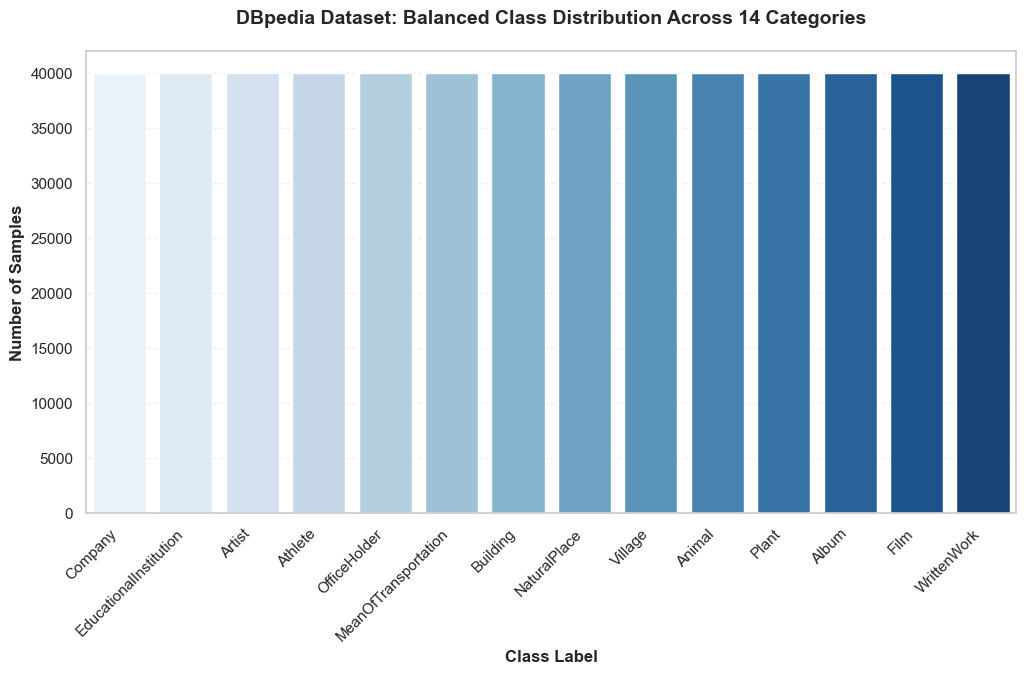

In [61]:

class_names = []
with open(os.path.join(DRIVE_ROOT, "classes.txt"), "r") as f:
    class_names = [line.strip() for line in f if line.strip()]

plt.figure(figsize=(12,6))
ax = sns.countplot(x=train_df["label"], palette="Blues")
plt.title("DBpedia Dataset: Balanced Class Distribution Across 14 Categories", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Class Label", fontsize=12, fontweight='bold')
plt.ylabel("Number of Samples", fontsize=12, fontweight='bold')
plt.xticks(range(14), [f"{class_names[i]}" if i < len(class_names) else str(i) for i in range(14)], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.show()


###Text Length Stats

count    560000.000000
mean         48.873950
std          22.693658
min           2.000000
25%          29.000000
50%          49.000000
75%          68.000000
max        1485.000000
Name: len_words, dtype: float64


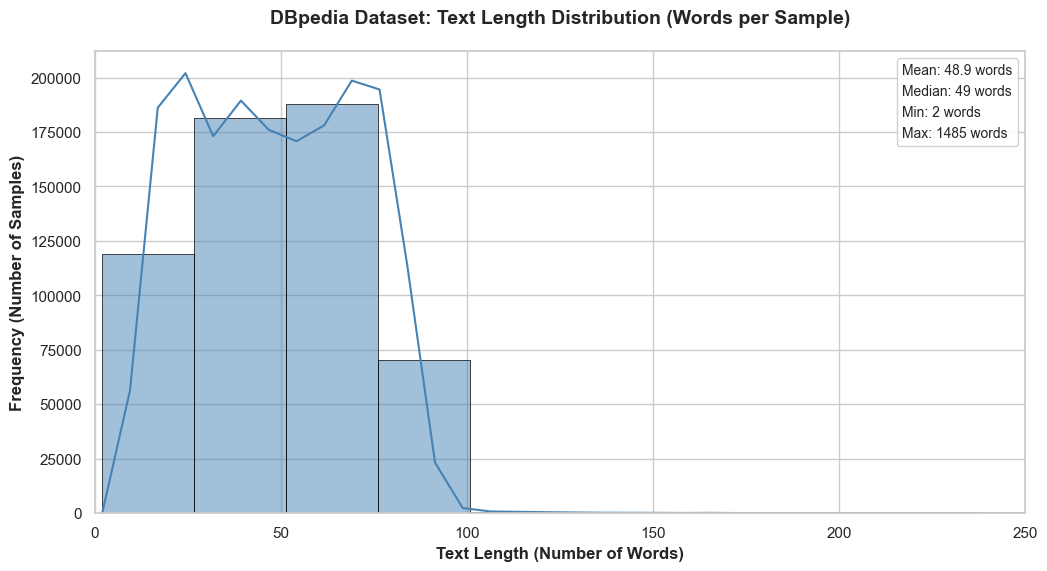

In [ ]:
train_df["len_words"] = train_df["text"].str.split().apply(len)
print(train_df["len_words"].describe())

plt.figure(figsize=(12,6))
ax = sns.histplot(train_df["len_words"], bins=60, kde=True, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlim(0, 250) 
plt.title("DBpedia Dataset: Text Length Distribution (Words per Sample)", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Text Length (Number of Words)", fontsize=12, fontweight='bold')
plt.ylabel("Frequency (Number of Samples)", fontsize=12, fontweight='bold')

# Custom Legend
from matplotlib.patches import Patch
legend_elements = [
    f'Mean: {train_df["len_words"].mean():.1f} words',
    f'Median: {train_df["len_words"].median():.0f} words',
    f'Min: {train_df["len_words"].min():.0f} words',
    f'Max: {train_df["len_words"].max():.0f} words'
]
plt.legend(handles=[Patch(facecolor='none', edgecolor='none', label=label) for label in legend_elements],
           loc='upper right', fontsize=10, framealpha=0.9, handlelength=0, handletextpad=0)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()


###Example Samples

In [15]:
for i in range(14):
    print(f"Label {i} Example:", train_df[train_df["label"]==i]["text"].iloc[0][:200], "\n---")


Label 0 Example: E. D. Abbott Ltd.  Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contr 
---
Label 1 Example: Dubai Gem Private School & Nursery.  Dubai Gem Private School (DGPS) is a British school located in the Oud Metha area of Dubai United Arab Emirates. Dubai Gem Nursery is located in Jumeirah. Together 
---
Label 2 Example: Erin Morgenstern.  Erin Morgenstern (born July 8 1978) is an American writer and visual artist best known for writing The Night Circus. 
---
Label 3 Example: Martin McKinnon.  Martin Marty McKinnon (born 5 July 1975 in Adelaide) is a former Australian rules footballer who played with Adelaide Geelong and the Brisbane Lions in the Australian Football League 
---
Label 4 Example: Augustus Porter.  Augustus S. Porter (January 18 1769 – June 10 1849) was an American businessman judge farmer and politician who served as an Assemblyman f

#Baseline Model: TF-IDF + Linear SVM

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ("clf", LinearSVC())
])

pipeline.fit(train_texts.tolist(), train_labels.tolist())


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [17]:
# Evaluation
svm_val_preds = pipeline.predict(val_texts.tolist())
svm_test_preds = pipeline.predict(test_df["text"].tolist())

In [18]:
print("Validation Report (TF-IDF + SVM):")
print(classification_report(val_labels, svm_val_preds))

Validation Report (TF-IDF + SVM):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4000
           1       0.99      0.99      0.99      4000
           2       0.98      0.97      0.98      4000
           3       1.00      1.00      1.00      4000
           4       0.99      0.98      0.98      4000
           5       0.99      0.99      0.99      4000
           6       0.98      0.98      0.98      4000
           7       0.99      1.00      0.99      4000
           8       1.00      1.00      1.00      4000
           9       0.99      0.99      0.99      4000
          10       0.99      0.99      0.99      4000
          11       0.99      0.99      0.99      4000
          12       0.99      0.99      0.99      4000
          13       0.98      0.98      0.98      4000

    accuracy                           0.99     56000
   macro avg       0.99      0.99      0.99     56000
weighted avg       0.99      0.99      0.99   

In [19]:
print("Test Report (TF-IDF + SVM):")
print(classification_report(test_df["label"], svm_test_preds))

Test Report (TF-IDF + SVM):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5000
           1       0.99      0.99      0.99      5000
           2       0.97      0.97      0.97      5000
           3       1.00      0.99      1.00      5000
           4       0.98      0.98      0.98      5000
           5       0.99      0.99      0.99      5000
           6       0.98      0.98      0.98      5000
           7       0.99      1.00      0.99      5000
           8       1.00      1.00      1.00      5000
           9       0.99      0.99      0.99      5000
          10       0.99      0.99      0.99      5000
          11       0.99      0.99      0.99      5000
          12       0.99      0.99      0.99      5000
          13       0.98      0.98      0.98      5000

    accuracy                           0.99     70000
   macro avg       0.99      0.99      0.99     70000
weighted avg       0.99      0.99      0.99     7000

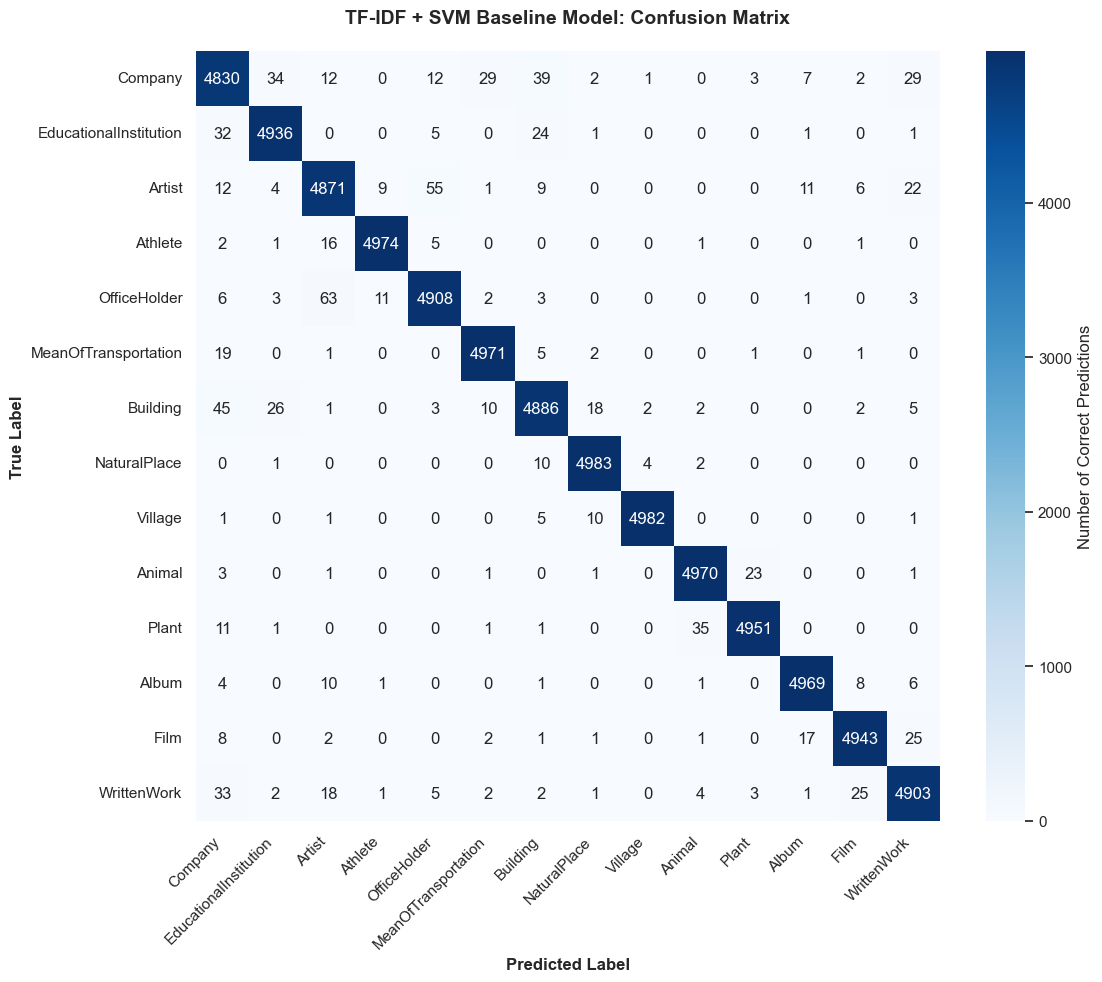

In [59]:
class_names = []
with open(os.path.join(DRIVE_ROOT, "classes.txt"), "r") as f:
    class_names = [line.strip() for line in f if line.strip()]

cm = confusion_matrix(test_df["label"], svm_test_preds)
plt.figure(figsize=(12,10))
ax = sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', cbar_kws={'label': 'Number of Correct Predictions'}, 
                 xticklabels=[f"{class_names[i]}" if i < len(class_names) else str(i) for i in range(14)],
                 yticklabels=[f"{class_names[i]}" if i < len(class_names) else str(i) for i in range(14)])
plt.title("TF-IDF + SVM Baseline Model: Confusion Matrix", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

#Save the trained TF-IDF + SVM baseline

In [21]:
import joblib

BASELINE_SAVE_PATH = os.path.join(DRIVE_ROOT, "tfidf_svm_baseline.pkl")
joblib.dump(pipeline, BASELINE_SAVE_PATH)

print("Saved baseline model to:", BASELINE_SAVE_PATH)


Saved baseline model to: c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\dbpedia_project\tfidf_svm_baseline.pkl


### Load the saved TF-IDF + SVM baseline later

In [22]:
import joblib

BASELINE_SAVE_PATH = os.path.join(DRIVE_ROOT, "tfidf_svm_baseline.pkl")
svm_baseline = joblib.load(BASELINE_SAVE_PATH)

print("Loaded baseline model.")


Loaded baseline model.


### Use it for predictions(only later)

In [23]:
preds = svm_baseline.predict(test_df["text"].tolist())

from sklearn.metrics import classification_report
print(classification_report(test_df["label"], preds))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5000
           1       0.99      0.99      0.99      5000
           2       0.97      0.97      0.97      5000
           3       1.00      0.99      1.00      5000
           4       0.98      0.98      0.98      5000
           5       0.99      0.99      0.99      5000
           6       0.98      0.98      0.98      5000
           7       0.99      1.00      0.99      5000
           8       1.00      1.00      1.00      5000
           9       0.99      0.99      0.99      5000
          10       0.99      0.99      0.99      5000
          11       0.99      0.99      0.99      5000
          12       0.99      0.99      0.99      5000
          13       0.98      0.98      0.98      5000

    accuracy                           0.99     70000
   macro avg       0.99      0.99      0.99     70000
weighted avg       0.99      0.99      0.99     70000



# Load Fine-Tuned DistilBERT from Drive

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_DIR)
model.to(device)
model.eval()

print("Loaded model on:", device)

c:\Users\johnb\Documents\TAMU\ECEN-758\ecen-758-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded model on: cpu


#Prepare Dataset for BERT Evaluation

In [25]:
from datasets import Dataset

test_ds = Dataset.from_dict({
    "text": test_df["text"].tolist(),
    "label": test_df["label"].tolist()
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=128)

test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])


Map: 100%|██████████| 70000/70000 [00:04<00:00, 17238.84 examples/s]


#Evaluate the Loaded BERT Model

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Manual prediction
all_preds = []
all_labels = []

for batch in test_ds:
    input_ids = batch["input_ids"].unsqueeze(0).to(device)
    attn = batch["attention_mask"].unsqueeze(0).to(device)
    label = batch["label"]

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attn).logits
        pred = logits.argmax(-1).item()

    all_preds.append(pred)
    all_labels.append(label)

In [27]:
print("Test Report (Loaded DistilBERT):")
print(classification_report(all_labels, all_preds, digits=4))

Test Report (Loaded DistilBERT):
              precision    recall  f1-score   support

           0     0.9781    0.9726    0.9753      5000
           1     0.9878    0.9910    0.9894      5000
           2     0.9843    0.9912    0.9877      5000
           3     0.9964    0.9982    0.9973      5000
           4     0.9914    0.9866    0.9890      5000
           5     0.9946    0.9970    0.9958      5000
           6     0.9872    0.9842    0.9857      5000
           7     0.9978    0.9970    0.9974      5000
           8     0.9980    0.9994    0.9987      5000
           9     0.9984    0.9990    0.9987      5000
          10     0.9990    0.9964    0.9977      5000
          11     0.9974    0.9962    0.9968      5000
          12     0.9974    0.9946    0.9960      5000
          13     0.9904    0.9948    0.9926      5000

    accuracy                         0.9927     70000
   macro avg     0.9927    0.9927    0.9927     70000
weighted avg     0.9927    0.9927    0.9927    

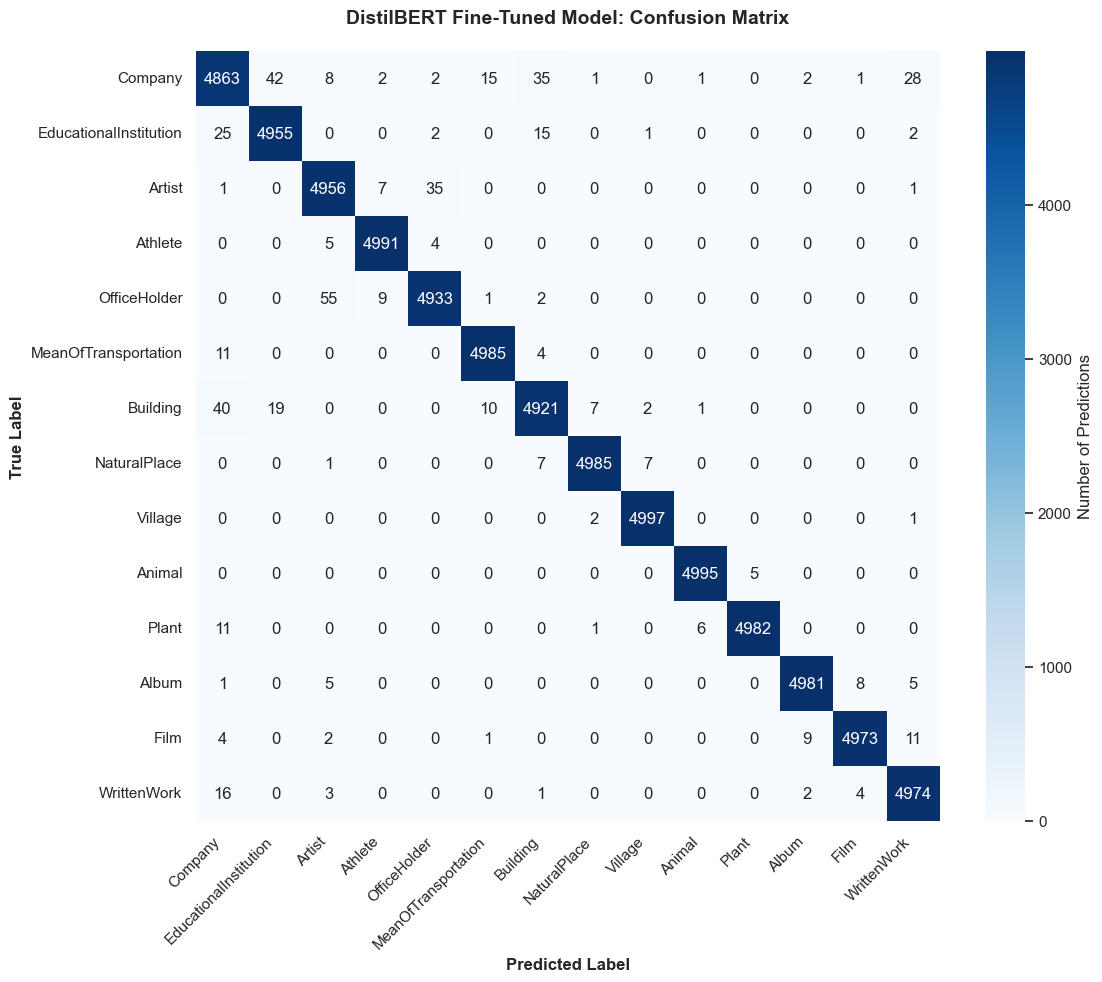

In [ ]:
class_names = []
with open(os.path.join(DRIVE_ROOT, "classes.txt"), "r") as f:
    class_names = [line.strip() for line in f if line.strip()]

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
ax = sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', cbar_kws={'label': 'Number of Correct Predictions'}, 
                 xticklabels=[f"{class_names[i]}" if i < len(class_names) else str(i) for i in range(14)],
                 yticklabels=[f"{class_names[i]}" if i < len(class_names) else str(i) for i in range(14)])
plt.title("DistilBERT Fine-Tuned Model: Confusion Matrix", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


#Compare SVM vs DistilBERT

In [29]:
from sklearn.metrics import accuracy_score, f1_score

svm_acc = accuracy_score(test_df["label"], svm_test_preds)
svm_f1  = f1_score(test_df["label"], svm_test_preds, average="weighted")

bert_acc = accuracy_score(all_labels, all_preds)
bert_f1  = f1_score(all_labels, all_preds, average="weighted")

summary = pd.DataFrame({
    "Model": ["TF-IDF + SVM", "DistilBERT"],
    "Accuracy": [svm_acc, bert_acc],
    "F1-weighted": [svm_f1, bert_f1]
})


In [30]:
summary

,Model,Accuracy,F1-weighted
0,TF-IDF + SVM,0.986814,0.986813
1,DistilBERT,0.992729,0.992725


#LIME Explainability

In [31]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=[str(i) for i in range(14)])

def predict_proba_for_lime(texts):
    model.eval()
    # Process texts in smaller batches to avoid OOM
    batch_size = 16 # Adjust based on GPU memory. 32-64 is usually a good starting point.
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)


ModuleNotFoundError: No module named 'lime'

###Pick a test sample

In [ ]:
sample_idx = 60
sample_text = test_df.iloc[sample_idx]["text"]
true_label  = test_df.iloc[sample_idx]["label"]

print("Text:", sample_text[:400])
print("True Label:", true_label)

exp = explainer.explain_instance(sample_text, predict_proba_for_lime, top_labels=1)
exp.show_in_notebook(text=True)


#Save LIME Outputs

In [ ]:
html = exp.as_html()
with open(os.path.join(MODEL_SAVE_DIR, "lime_sample.html"), "w") as f:
    f.write(html)

print("Saved at:", os.path.join(MODEL_SAVE_DIR, "lime_sample.html"))
